In [2]:
## 📚 Libraries
!pip install pingouin
!pip install statstests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as ww
from ydata_profiling import ProfileReport
from scipy.stats import probplot, yeojohnson, f_oneway, chi2_contingency
from pingouin import rcorr
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statstests.tests import shapiro_francia
from statstests.process import stepwise

%matplotlib inline
ww.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.4 MB/s eta 0:00:00a 0:00:01
/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


## 🦆 Predicting Podcast Listening Time

This notebook walks through the process of preparing and modeling data to predict podcast listening time, using both statistical methods and machine learning.

## 🔍 Exploratory Data Analysis (EDA)

In [5]:
## 📂 Load Data
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

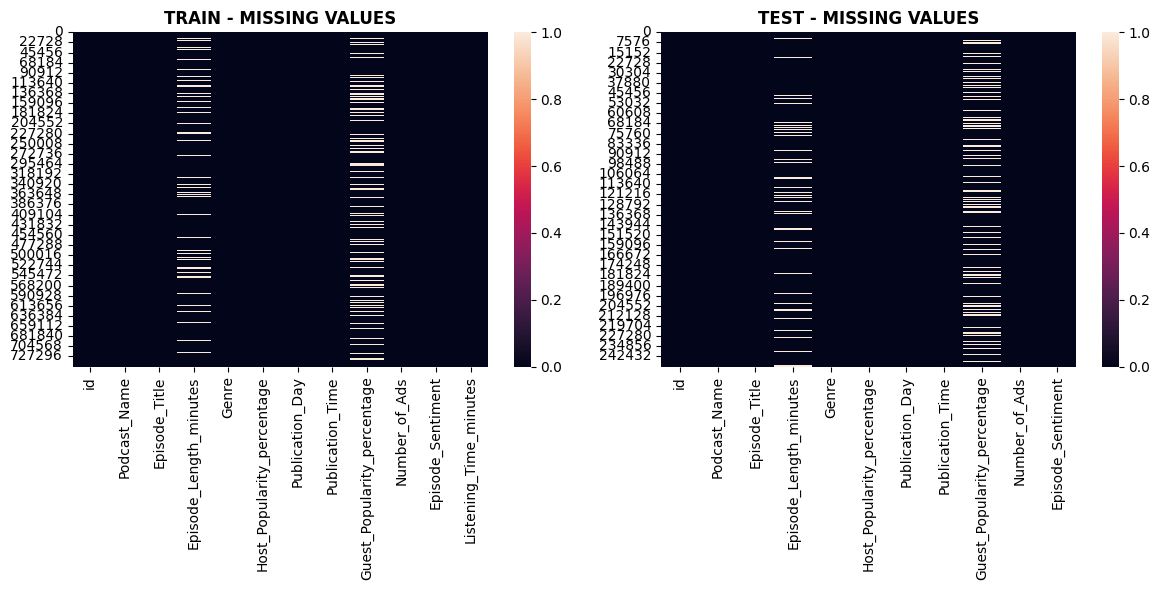

In [8]:
## Missing Values Heatmap
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("TRAIN - MISSING VALUES", weight="bold")
sns.heatmap(data=train.isna())
plt.subplot(1,2,2)
plt.title("TEST - MISSING VALUES", weight="bold")
sns.heatmap(data=test.isna())
plt.tight_layout()

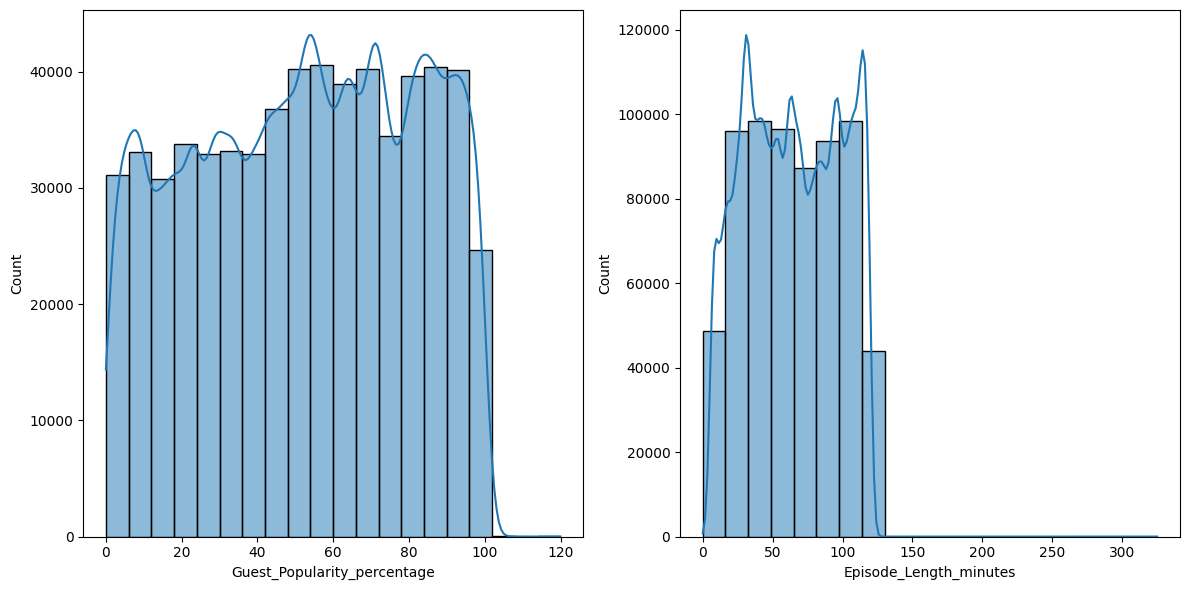

In [6]:
### Variable Distributions
plt.figure(figsize=(12,6))
plt.title("TRAIN SET DISTRIBUTIONS\n", weight="bold")
plt.subplot(1,2,1)
sns.histplot(data=train['Guest_Popularity_percentage'], kde=True, bins=20)
plt.subplot(1,2,2)
sns.histplot(data=train['Episode_Length_minutes'], kde=True, bins=20)
plt.tight_layout()

In [7]:
## 🧹 Handling Missing Data
train[['Guest_Popularity_percentage', 'Episode_Length_minutes']].fillna(train[['Guest_Popularity_percentage', 'Episode_Length_minutes']].median(), inplace=True)
test[['Guest_Popularity_percentage', 'Episode_Length_minutes']].fillna(train[['Guest_Popularity_percentage', 'Episode_Length_minutes']].median(), inplace=True)
train.dropna(inplace=True)

In [8]:
## 📏 Outlier Removal using IQR Method
# We remove outliers from the target variable `Listening_Time_minutes` using the interquartile range (IQR) technique:
Q1 = train['Listening_Time_minutes'].quantile(0.25)
Q3 = train['Listening_Time_minutes'].quantile(0.75)
IQR = Q3 - Q1
LCI = Q1 - 1.5 * IQR
LCS = Q3 + 1.5 * IQR
train = train[(train['Listening_Time_minutes'] >= LCI) & (train['Listening_Time_minutes'] <= LCS)]


## 🔄 Target Normalization using Yeo-Johnson Transformation

**Yeo-Johnson** is a transformation technique to make data more Gaussian-like and suitable for linear models.
It handles both positive and negative values.

In [ ]:
from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer
transformador_yeojohnson = PowerTransformer(method='yeo-johnson', standardize=False)
train['Listening_Time_minutes_yeojohnson'] = transformador_yeojohnson.fit_transform(train['Listening_Time_minutes'].values.reshape(-1,1))

### Assessing Normality with Shapiro-Francia Test

**Shapiro-Francia Test** is a variation of the Shapiro-Wilk test for normality and is particularly suitable for larger datasets.

In [ ]:
from statstests.tests import shapiro_francia
shapiro_francia(train['Listening_Time_minutes_yeojohnson'])

method  :  Shapiro-Francia normality test
statistics W  :  0.9874557506647988
statistics z  :  26.892657993540805
p-value  :  1.3382101265679473e-159


{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9874557506647988,
 'statistics z': 26.892657993540805,
 'p-value': 1.3382101265679473e-159}

## 🎧 Feature Engineering

In [12]:
### Cleaning `Episode_Title`
train['Episode_Title'].replace('Episode ', '', regex=True, inplace=True)
train['Episode_Title'] = pd.to_numeric(train['Episode_Title'])
test['Episode_Title'].replace('Episode ', '', regex=True, inplace=True)
test['Episode_Title'] = pd.to_numeric(train['Episode_Title'])

## 🔍 Analyzing `Podcast_Name` and Genre Dependency
### Cramér's V for Categorical Association

**Cramér’s V** is a measure of association between two nominal variables, giving a value between 0 and +1.

![Cramer's V](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Cramer%27s_V.svg/640px-Cramer%27s_V.svg.png)


In [13]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k, r = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

print("Cramér’s V:", cramers_v(train['Genre'], train['Podcast_Name']))

Cramér’s V: 0.9974265932847686


## 📊 Relationship Between Sentiment and Listening Time

### ANOVA and Tukey HSD Test

We use ANOVA to test whether means between sentiment groups are significantly different. If they are, we use Tukey's HSD test to find which pairs differ.

**Tukey’s Honest Significant Difference (HSD)** compares all possible pairs of means.

In [15]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Separa os dados de Listening_Time_minutes por sentimento
grupo_negativo = train[train['Episode_Sentiment'] == 'Negative']['Listening_Time_minutes']
grupo_neutro = train[train['Episode_Sentiment'] == 'Neutral']['Listening_Time_minutes']
grupo_positivo = train[train['Episode_Sentiment'] == 'Positive']['Listening_Time_minutes']

# ANOVA test
f_stat, p_valor = f_oneway(grupo_negativo, grupo_neutro, grupo_positivo)

# Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=train['Listening_Time_minutes'],
    groups=train['Episode_Sentiment'],
    alpha=0.05)

print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1   group2  meandiff p-adj lower  upper  reject
-----------------------------------------------------
Negative  Neutral   1.4359   0.0 1.2236 1.6483   True
Negative Positive   2.3779   0.0 2.1648 2.5909   True
 Neutral Positive   0.9419   0.0  0.729 1.1549   True
-----------------------------------------------------


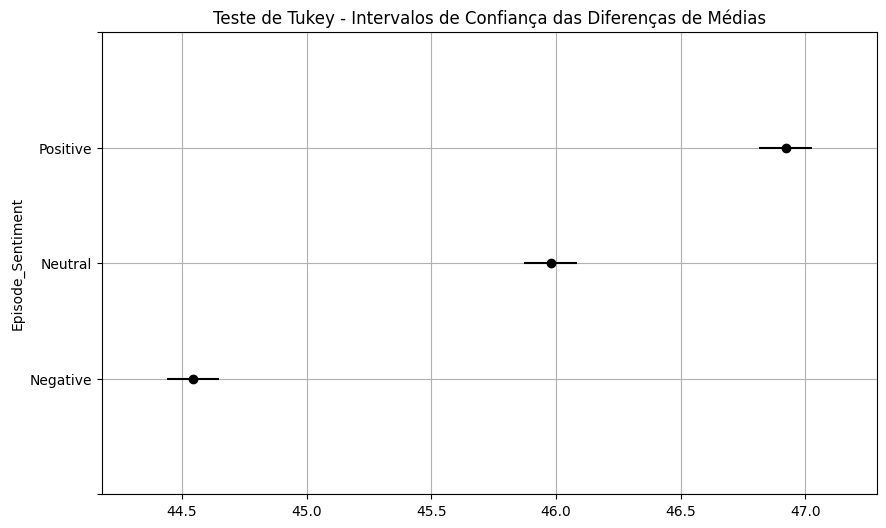

In [25]:
# Plot Tukey Result w/ Confiance Interval
fig = tukey_result.plot_simultaneous(comparison_name=None, ylabel='Episode_Sentiment')
plt.title('Teste de Tukey - Intervalos de Confiança das Diferenças de Médias')
plt.grid(True)
plt.show()

## 🧠 Base Linear Model and Stepwise Selection

We fit an OLS model and use a stepwise selection approach to find the best subset of predictors:

In [17]:
from statsmodels.api import OLS
from statstests.process import stepwise

train = train[['Episode_Title', 'Episode_Length_minutes', 'Podcast_Name',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes_yeojohnson']]
test = test[['Episode_Title', 'Episode_Length_minutes', 'Podcast_Name',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment']]

train = pd.get_dummies(train, drop_first=True, dtype='int')
test = pd.get_dummies(test, drop_first=True, dtype='int')

train.columns = train.columns.str.strip().str.replace(' ', '_')
train.columns = train.columns.str.strip().str.replace('_&_', '_')
test.columns = test.columns.str.strip().str.replace(' ', '_')
test.columns = test.columns.str.strip().str.replace('_&_', '_')

X = train.drop('Listening_Time_minutes_yeojohnson', axis=1)
y = train['Listening_Time_minutes_yeojohnson']

variaveis = " + ".join(X.columns)
formula = "Listening_Time_minutes_yeojohnson ~ " + variaveis
print(formula)
base_model = OLS.from_formula(formula, data=train).fit()
stepwise_model = stepwise(base_model)

Listening_Time_minutes_yeojohnson ~ Episode_Title + Episode_Length_minutes + Host_Popularity_percentage + Guest_Popularity_percentage + Number_of_Ads + Podcast_Name_Brain_Boost + Podcast_Name_Business_Briefs + Podcast_Name_Business_Insights + Podcast_Name_Comedy_Corner + Podcast_Name_Crime_Chronicles + Podcast_Name_Criminal_Minds + Podcast_Name_Current_Affairs + Podcast_Name_Daily_Digest + Podcast_Name_Detective_Diaries + Podcast_Name_Digital_Digest + Podcast_Name_Educational_Nuggets + Podcast_Name_Fashion_Forward + Podcast_Name_Finance_Focus + Podcast_Name_Fitness_First + Podcast_Name_Funny_Folks + Podcast_Name_Gadget_Geek + Podcast_Name_Game_Day + Podcast_Name_Global_News + Podcast_Name_Health_Hour + Podcast_Name_Healthy_Living + Podcast_Name_Home_Living + Podcast_Name_Humor_Hub + Podcast_Name_Innovators + Podcast_Name_Joke_Junction + Podcast_Name_Laugh_Line + Podcast_Name_Learning_Lab + Podcast_Name_Life_Lessons + Podcast_Name_Lifestyle_Lounge + Podcast_Name_Market_Masters + Podcast

## 🔮 Inverse Yeo-Johnson for Predictions

Predictions are reverted back from the transformed scale using the inverse Yeo-Johnson transformation.

In [21]:
def inverse_yeojohnson(x_trans, lmbda):
    """
    Inverte a transformação Yeo-Johnson.

    Parâmetros:
        x_trans: array-like, valores transformados
        lmbda: float, parâmetro lambda usado na transformação Yeo-Johnson

    Retorna:
        x_original: array-like, valores antes da transformação
    """
    x_trans = np.asarray(x_trans)
    x_original = np.zeros_like(x_trans)

    # Para x >= 0
    pos_mask = x_trans >= 0
    if lmbda != 0:
        x_original[pos_mask] = np.power(x_trans[pos_mask] * lmbda + 1, 1 / lmbda) - 1
    else:
        x_original[pos_mask] = np.exp(x_trans[pos_mask]) - 1

    # Para x < 0
    neg_mask = x_trans < 0
    if lmbda != 2:
        x_original[neg_mask] = 1 - np.power(-(2 - lmbda) * x_trans[neg_mask] + 1, 1 / (2 - lmbda))
    else:
        x_original[neg_mask] = 1 - np.exp(-x_trans[neg_mask])

    return x_original

ypred_submission = stepwise_model.predict(test)
ypred_submission = inverse_yeojohnson(ypred_submission, transformador_yeojohnson.lambdas_)


## 🚀 XGBoost Model with Hyperparameter Tuning

We apply a tuned XGBoost Regressor using `GridSearchCV` to improve prediction accuracy.

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [30]:
# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Scorer to use w/ GridSearchCV
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Start the Model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Params Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Cruzader Validations
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search w/ RMSE
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Training the Model
X = X[['Episode_Title', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Podcast_Name_Brain_Boost', 'Podcast_Name_Business_Briefs', 'Podcast_Name_Business_Insights', 'Podcast_Name_Comedy_Corner', 'Podcast_Name_Criminal_Minds', 'Podcast_Name_Digital_Digest', 'Podcast_Name_Educational_Nuggets', 'Podcast_Name_Fashion_Forward', 'Podcast_Name_Global_News', 'Podcast_Name_Humor_Hub', 'Podcast_Name_Innovators', 'Podcast_Name_Joke_Junction', 'Podcast_Name_Laugh_Line', 'Podcast_Name_Learning_Lab', 'Podcast_Name_Lifestyle_Lounge', 'Podcast_Name_Market_Masters', 'Podcast_Name_Melody_Mix', 'Podcast_Name_Money_Matters', 'Podcast_Name_Music_Matters', 'Podcast_Name_Mystery_Matters', 'Podcast_Name_Sound_Waves', 'Podcast_Name_Sport_Spot', 'Podcast_Name_Sports_Central', 'Podcast_Name_Tech_Trends', 'Podcast_Name_World_Watch', 'Genre_Comedy', 'Genre_Education', 'Genre_Lifestyle', 'Genre_Music', 'Genre_News', 'Genre_Sports', 'Genre_Technology', 'Genre_True_Crime', 'Publication_Day_Saturday', 'Publication_Day_Sunday', 'Publication_Day_Tuesday', 'Publication_Day_Wednesday', 'Publication_Time_Evening', 'Publication_Time_Night', 'Episode_Sentiment_Neutral', 'Episode_Sentiment_Positive']]
grid_search.fit(X.iloc[:500,:], y.iloc[:500])

# Results
print(f"Best params: {grid_search.best_params_}")
print(f"Best RMSE (negative): {grid_search.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best RMSE (negative): -2.379750000815234


In [32]:
#%% PREDICT W/ TEST
features_stepwise = X.columns
ypred_xgb = grid_search.predict(test[features_stepwise])
ypred_xgb = inverse_yeojohnson(ypred_xgb, transformador_yeojohnson.lambdas_)

submission = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")
submission['Listening_Time_minutes'] = ypred_xgb
submission.to_csv('/kaggle/working/submisson.csv', index=False)